This notebook trains the models (both the ResNet50 alone and the chain configuration set up)

# Importing Needed Modules

In [2]:
import numpy as np
import pandas as pd
import os, time, shutil, hickle
from tqdm import tqdm
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.8)
sns.set_style('white')
import hickle

import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models

import sklearn
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.model_selection import train_test_split
from PIL import Image as image_PIL
from PIL import Image, ImageOps
import PIL
from PIL import ImageShow
from astropy.io import fits

from zoobot.pytorch.estimators import define_model as ZoobotModel

# Importing Data

In [2]:
work_dir = 'INSTERT DIRECTORY OF THE GITCLONED FOLDER HERE'


# Defining Data Structure Layout

For non morpholgical loaders

In [63]:
# manga_cat = hickle.load(work_dir+'manga_training_labels_d4000.cat')
def resize_image(src_image, size=(256,256), bg_color="black"): 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

def load_image_data(idlist, size=(256,256), bg_color="black"):
    
    images = []
    for gal_id in tqdm(idlist):
        #img = plt.imread('images/'+gal_id+'.png')
        img = Image.open(work_dir+'images (DR17)/'+gal_id+'.png')
        img_sized = resize_image(img, size=size, bg_color=bg_color)
        images.append(img_sized)
    return images

class MaNGAdataset(Dataset):
    """images and labels for CNN"""
    
    def __init__(self, manga_cat, galmask, transform = None):
        
        gal_ids = manga_cat['manga_id']
        gal_ids = np.array(gal_ids,dtype=str)[galmask]
        gal_mass = manga_cat['log_mstar'][galmask]
        #gal_mass_scaled = (gal_mass - 9)/4
        gal_mass_scaled = gal_mass
        gal_sfr = manga_cat['log_sfr'][galmask]
        gal_z = manga_cat['redshift'][galmask]
        gal_n = manga_cat['sersic_n'][galmask]
        gal_t50 = np.log10(manga_cat['t50'])[galmask]
        gal_d4000 = manga_cat['d4000'][galmask]

        # good_index = np.where(gal_sfr != -np.inf)[0]
        good_index = np.where(np.array(gal_d4000,dtype=str) != 'nan')[0] #cleaning out nan values of d4000 

        gal_ids = gal_ids[good_index]
        gal_mass = gal_mass[good_index]
        gal_sfr = gal_sfr[good_index]
        gal_z = gal_z[good_index]
        gal_n = gal_n[good_index]
        gal_t50 = gal_t50[good_index]
        gal_d4000 = gal_d4000[good_index]

        ###########CLASSIC CLASSES#######################

        bars=np.linspace(np.min(gal_sfr), np.max(gal_sfr), num=11) #Number of classes set here (+1), default was 20 
        sfr_cat = np.zeros_like(gal_sfr)
        for i in range(len(bars)-1):
            sfr_cat[(gal_sfr > bars[i]) & (gal_sfr < bars[i+1])]=int(i)
        sfr_cat[gal_sfr > bars[len(bars)-1]] = int(len(bars)-1)

        ########################NEW MORE EVENLY DISTRIBUTED CLASSES###################
        
        # bars=[-6,-2.5,-2,-1.7,-1.5,-1.2,-0.9,-0.7,-0.4,-0.1,0.1,0.9]
        # sfr_cat = np.zeros_like(gal_sfr)
        # for i in range(len(bars)-1):
        #     sfr_cat[(gal_sfr > bars[i]) & (gal_sfr < bars[i+1])]=int(i)
        # sfr_cat[gal_sfr > bars[len(bars)-1]] = int(len(bars)-1)
      
        self.image = load_image_data(gal_ids)
        self.mangaid = gal_ids
        self.mstar = gal_mass
        self.mstar_class = gal_mass
        self.sfr = sfr_cat
        self.z = gal_z
        self.n = gal_n
        #self.c = ((gal_mass - 6)*3 - 1).astype(int)
        self.c = sfr_cat.astype(int)
        self.transform = transform
        self.sfr_value = gal_sfr
        self.t50 = gal_t50
        self.d4000 = gal_d4000

        
    def __len__(self):
        return len(self.mstar)
    
    def __getitem__(self, idx):
    
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = {'image': self.image[idx],
                'mass': self.mstar[idx],
                'z':self.z[idx],
                'n':self.n[idx],
                'sfr_class':self.sfr[idx],
                'mangaid':self.mangaid[idx],
                'sfr':self.sfr_value[idx],
                't50':self.t50[idx],
                'd4000':self.d4000[idx]}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])

            
            
        return sample

# Creating Data Loaders

In [ ]:
ngal = len(manga_cat['redshift'])
n_ttsplit = int(ngal*0.9)
#transform = None
#transform = transforms.ToTensor()
batch_size = 32

transform = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        # transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        # transforms.RandomVerticalFlip(0.5),
        #Rotates the image by some angle
        # transforms.RandomRotation(degrees = (0,360)),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

# transform0 = transforms.Compose([
#         # Randomly augment the image data
#             # Random horizontal flip
#         transforms.RandomHorizontalFlip(0.5),
#         transforms.ToTensor()])
#             # Random vertical flip
# transform1 = transforms.Compose([ transforms.RandomVerticalFlip(0.5),
# transforms.ToTensor()])
#         #Rotates the image by some angle

# transforms2 = transforms.Compose([transforms.RandomRotation(degrees = (0,360)),
# transforms.ToTensor()])
        
# transforms3 = transforms.Compose([transforms.ToTensor()])

# transform = [transform0,transform1,transforms2,transforms3]





train_data = MaNGAdataset(manga_cat, (np.arange(ngal) <= n_ttsplit),
    transform=transform
)

val_data = MaNGAdataset(manga_cat, (np.arange(ngal) > n_ttsplit),
    transform=transform
)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers = 0
)

val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers = 0
)

In [5]:
train_loader = hickle.load(work_dir+'dataloaders/Train_Manga_DR17_d4000')
val_loader = hickle.load(work_dir+'dataloaders/Test_Manga_DR17_d4000')

# Defining Network Architecture

In [24]:
# model_used = 'baseline_sfr_log_t50_chain_90_10'
model_used = 'sfr_solo'

ResNet50 Mass

In [ ]:
from torchvision import models
model_mass = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')

#Loop to freeze all ResNet50 Layers Except the Last Conv Layer
i=0
for param in model.parameters():
  if i < 144:,
    param.requires_grad = False
  print(i)
  print(param.shape)
  print(param.requires_grad)
  i=i+1
model_mass.fc = nn.Linear(2048, 1)

ResNet50 SFR

In [28]:
model_sfr = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')

#Allows for additional input of mass along with image, only used when in the chain configuration 
#ONLY RUN IF USING CHAIN CONFIGUATION
model_sfr.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,bias=False)


i=0
for param in model.parameters():
  if i < 144:,
    param.requires_grad = False
  print(i)
  print(param.shape)
  print(param.requires_grad)
  i=i+1
model_sfr.fc = nn.Linear(2048, 1)




ResNet50 t50

In [29]:
model_t50 = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
#Allows for additional input of mass+SFR along with image, only used when in the chain configuration
#ONLY RUN IF USING CHAIN CONFIGUATION
model_t50.conv1 = nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3,bias=False)

#Loop to freeze all ResNet50 Layers Except the Last Conv Layer
i=0
for param in model.parameters():
  if i < 144:,
    param.requires_grad = False
  print(i)
  print(param.shape)
  print(param.requires_grad)
  i=i+1
model_t50.fc = nn.Linear(2048, 1)



# Defining the Train and Test Loops

In [8]:
import warnings
warnings.filterwarnings('ignore')

1 or 3 Target Setup (NOT CHAIN)

In [14]:
r2_train = np.zeros(4)
r2_test = np.zeros(4)


def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    
    # Process the images in batches
    for batch_idx, temp in enumerate(train_loader):
        
        data = temp['image']
        target = temp['sfr']
        # target1 = temp['mass']
        # target2= temp['t50']
        # target2 = temp['d4000']
        #
        target=target.float()
        target=target.reshape(-1,1)
        # target1=target1.float()
        # target1=target1.reshape(-1,1)
        # target2=target2.float()
        # target2=target2.reshape(-1,1)
        # print(target.shape)
#         target=target.reshape(-1,1)
        
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        # data, target, target1,target2 = data.to(device), target.to(device), target1.to(device), target2.to(device)
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        # output, output1, output2 = model(data)[:,0], model(data)[:,1], model(data)[:,2]
        output = model(data)

        # Get the loss
        loss = loss_criteria(output, target)
        # loss1 = loss_criteria1(output1,target)
        # loss2 = loss_criteria2(output2,target)
        # loss = loss0+loss1+loss2
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Keep a running total
        train_loss += loss.item()

        

        if batch_idx < 4:
            r2_train[batch_idx] =r2_score(np.array(target.detach().cpu().numpy()),np.array(output.detach().cpu().numpy()))
            # plt.subplot(1,3,1)
            # plt.title('SFR')
            plt.title('SFR')
            plt.plot(target.detach().cpu().numpy(), output.detach().cpu().numpy(),'bo')
            plt.plot([0.8,1],[0.8,1],'k--')
            # plt.subplot(1,3,2)
            # plt.title('Mass')
            # plt.plot(target1.detach().cpu().numpy(), output1.detach().cpu().numpy(),'bo')
            # plt.plot([6,18],[6,18],'k--')
            
            # plt.subplot(1,3,3)
            # plt.title('t50')
            # plt.plot(target2.detach().cpu().numpy(), output2.detach().cpu().numpy(),'bo')
            # plt.plot([0,13],[0,13],'k--')
            
    plt.text(0,-6,'$R^2$ Train ='+str(np.mean(r2_train))[0:5],fontsize='small')
            

    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for batch_idx, temp in enumerate(test_loader):
        
            data = temp['image']
            target = temp['sfr']
            # target1 = temp['mass']
            # target2= temp['t50']
            # target2 = temp['d4000']
            
            target=target.float()
            target=target.reshape(-1,1)
            # target1=target1.float()
            # target1=target1.reshape(-1,1)
            # target2=target2.float()
            # target2=target2.reshape(-1,1)
            
            batch_count += 1
            # data, target, target1, target2 = data.to(device), target.to(device), target1.to(device), target2.to(device)
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            # output, output1, output2 = model(data)[:,0], model(data)[:,1], model(data)[:,2]
            output = model(data)
            
            # Calculate the loss for this batch
            loss = loss_criteria(output, target)
            # loss1 = loss_criteria1(output1, target1)
            # loss2 = loss_criteria2(output2, target2)
            # loss=loss0+loss1+loss2

            test_loss += loss.item()
            
            # Calculate the accuracy for this batch
            # _, predicted = torch.max(output.data, 1)
            # correct += torch.sum(target==predicted).item()

            if batch_idx < 4:
                # plt.subplot(1,3,1)
                plt.title('SFR')
                # plt.title('d4000')
                plt.plot(target.detach().cpu().numpy(), output.detach().cpu().numpy(),'ro')
                plt.plot([0.8,2],[0.8,2],'k--')
                # plt.subplot(1,3,2)
                # plt.title('Mass')
                # plt.plot(target1.detach().cpu().numpy(), output1.detach().cpu().numpy(),'ro')
                # plt.plot([6,18],[6,18],'k--')
                
                # plt.subplot(1,3,3)
                # plt.title('t50')
                # plt.plot(target2.detach().cpu().numpy(), output2.detach().cpu().numpy(),'ro')
                # plt.plot([0,13],[0,13],'k--')
                r2_test[batch_idx] = r2_score(np.array(target.detach().cpu().numpy()),np.array(output.detach().cpu().numpy()))
            
        plt.text(0,-6.5,'$R^2$ Test ='+str(np.mean(r2_test))[0:5],fontsize='small')
            



    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    # print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\\n'.format(
    #     avg_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)))
    
    print('Validation set: Average loss: %.6f' %(
        avg_loss))


    # Calculate the average loss and total accuracy for this epoch
    # avg_loss = test_loss / batch_count
    # print('Validation set: Average loss: %.6f' %(avg_loss))
    
    # return average loss for the epoch
    return avg_loss

Chain Network Setup

In [31]:
batch_size=32
def train(model1, model2, model3, device, train_loader,optimizer,optimizer1, optimizer2, epoch):
    # Set the model to training mode
    model1.train()
    model2.train()
    # model3.train()
    model3.train()
    j=0
    train_loss0 = 0
    train_loss1 = 0
    train_loss2 = 0
    train_loss3 = 0
    train_loss4 = 0
    print("Epoch:", epoch)
    
    # Process the images in batches
    for batch_idx, temp in enumerate(train_loader):
        
        data = temp['image']
        target = temp['sfr']
        target1 = temp['mass']
        # target2 = temp['t50']
        target2 = temp['d4000']
        # target3 = temp['z']
        target=target.float()
        target1=target1.float()
        target2=target2.float()
        # target3=target3.float()
#         target=target.long()
        # print(target.shape)
        target=target.reshape(-1,1)
        target1=target1.reshape(-1,1)
        target2=target2.reshape(-1,1)
        # target3=target3.reshape(-1,1)
        
        # target=torch.nan_to_num(target)
        # target1=torch.nan_to_num(target1,nan=13.976690195804084)
        # target2=torch.nan_to_num(target2)


        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target, target1,target2= data.to(device), target.to(device), target1.to(device),target2.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        
        
        # Push the data forward through the  different models
        output1=model1(data)
        
        #Taking into account remainder from the batch (in this case 6933 galaxies means 216 complete batches and 21 left over) (70/30 split)
        # Taking into account remainder from the batch (in this case 8914 galaxies means 278 complete batches and 18 left over) (90/10 split)
        # complete_batches_train = 278 
        # remainder_train = 18

        #For d4000 dataloaders
        complete_batches_train = 278 
        remainder_train = 2


        

        output1_aug=np.ones((32,1,256,256))
        output1_aug_special=np.ones((remainder_train,1,256,256))

        output2_aug=np.ones((32,1,256,256))
        output2_aug_special=np.ones((remainder_train,1,256,256))

      

        if j<complete_batches_train:
            for i in range(batch_size):
                output1_aug[i,:,:,:]=output1.detach().cpu().numpy()[i,:]*np.ones((256,256))
            
            tensor_output1_aug=torch.tensor(output1_aug).float().to(device)

            data=torch.concat((data,tensor_output1_aug),1)
            output2=model2(data)
            # print(output2)

            for i in range(batch_size):
                output2_aug[i,:,:,:]=output2.detach().cpu().numpy()[i,:]*np.ones((256,256))
            
            tensor_output2_aug=torch.tensor(output2_aug).float().to(device)

                
            data=torch.concat((data,tensor_output2_aug),1)

            output3=model3(data)
            # print(output3)



        
        else:
            for i in range(remainder_train):
                output1_aug_special[i,:,:,:]=output1.detach().cpu().numpy()[i,:]*np.ones((256,256))
                
            tensor_output1_aug=torch.tensor(output1_aug_special).float().to(device)

            data=temp['image'].to(device)
            data=torch.concat((data,tensor_output1_aug),1)
            # print('This is for the special case:', data.size())
            output2=model2(data)

            for i in range (remainder_train):
                output2_aug_special[i,:,:,:]=output2.detach().cpu().numpy()[i,:]*np.ones((256,256))
            
            tensor_output2_aug=torch.tensor(output2_aug_special).float().to(device)
        
            data=torch.concat((data,tensor_output2_aug),1)

            output3=model3(data)


        j=j+1
        

        
        
        
        # print(output,target)

        # Get the loss
        # loss0 = loss_criteria(output, target3)
        loss1 = loss_criteria(output1, target1)
        loss2 = loss_criteria1(output2, target)
        loss3 = loss_criteria2(output3,target2)
        # Backpropagate
        # loss0.backward()
        loss1.backward()
        loss2.backward()
        loss3.backward()

        optimizer.step()
        optimizer1.step()
        optimizer2.step()
        
        
        # Keep a running total
        # train_loss0 += loss0.item()
        train_loss1 += loss1.item()
        train_loss2 += loss2.item()
        train_loss3 += loss3.item()
        
        

        if batch_idx < 4:

            plt.subplot(1,3,1)
            plt.title('Mass')
            plt.plot(target1.detach().cpu().numpy(), output1.detach().cpu().numpy(),'bo')
            plt.plot([9,13],[9,13],'k--')
            plt.subplot(1,3,2)
            plt.title('SFR')
            plt.plot(target.detach().cpu().numpy(), output2.detach().cpu().numpy(),'bo')
            plt.plot([-7,1],[-7,1],'k--')
            plt.subplot(1,3,3)
            plt.title('t50')
            plt.plot(target2.detach().cpu().numpy(), output3.detach().cpu().numpy(),'bo')
            plt.plot([0.8,2],[0.8,2],'k--')
            # plt.subplot(1,4,4)
            # plt.title('Redshift')
            # plt.plot(target3.detach().cpu().numpy(), output.detach().cpu().numpy(),'bo')
            # plt.plot([0,0.15],[0,0.15],'k--')

            



    # return average loss for the epoch
    # avg_loss0 = train_loss0 / (batch_idx+1)
    # avg_loss1 = train_loss1 / (batch_idx+1)
    
    # avg_loss2 = train_loss2 / (batch_idx+1)
    avg_loss3 = train_loss3 / (batch_idx+1)
    # print('Training set: Average Redshift loss: {:.6f}'.format(avg_loss0))
    # print('Training set: Average Mass loss: {:.6f}'.format(avg_loss1))
    # print('Training set: Average SFR loss: {:.6f}'.format(avg_loss2))
    print('Training set: Average SFH loss: {:.6f}'.format(avg_loss3))
    return avg_loss3
    # , avg_loss1, avg_loss2,avg_loss3

def test(model1, model2, model3, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model1.eval()
    model2.eval()
    model3.eval()
    test_loss0 = 0
    test_loss1 = 0
    test_loss2 = 0
    test_loss3 = 0
    correct = 0
    k=0
    with torch.no_grad():
        batch_count = 0
        for batch_idx, temp in enumerate(test_loader):
        
            data = temp['image']
            target = temp['sfr']
            target1 = temp['mass']
            # target2 = temp['t50']
            target2 = temp['d4000']
            # target3=temp['z']
            target=target.float()
            target1=target1.float()
            target2=target2.float()
            # target3=target3.float()
            #target=target.long()
            # print(target.shape)
            target=target.reshape(-1,1)
            target1=target1.reshape(-1,1)
            target2=target2.reshape(-1,1)
            # target3=target3.reshape(-1,1)

            # target=torch.nan_to_num(target)
            # target1=torch.nan_to_num(target1,nan=13.976690195804084)
            # target2=torch.nan_to_num(target2)

            
            
            batch_count += 1
            data, target, target1,target2= data.to(device), target.to(device), target1.to(device),target2.to(device)
            
            output1=model1(data)

            #Taking into account remainder from the batch (in this case 2971 galaxies means 92 complete batches and 27 left over), k index used instead of j to avoid confusion with train loop
            
            # for (90/10) split we have 990 galaxies means 30 complete batches and 30 left over 
            # complete_batches_test = 30 
            # remainder_test = 30

             #For d4000 dataloaders
            complete_batches_test = 30 
            remainder_test = 26
        

            output1_aug=np.ones((32,1,256,256))
            output1_aug_special=np.ones((remainder_test,1,256,256))

            output2_aug=np.ones((32,1,256,256))
            output2_aug_special=np.ones((remainder_test,1,256,256))

          
            
            
            if k<complete_batches_test:
                for i in range(batch_size):
                    output1_aug[i,:,:,:]=output1.detach().cpu().numpy()[i,:]*np.ones((256,256))
                
                tensor_output1_aug=torch.tensor(output1_aug).float().to(device)

                data=torch.concat((data,tensor_output1_aug),1)
                
                output2=model2(data)

                for i in range(batch_size):
                    output2_aug[i,:,:,:]=output2.detach().cpu().numpy()[i,:]*np.ones((256,256))
            
                tensor_output2_aug=torch.tensor(output2_aug).float().to(device)

                data=torch.concat((data,tensor_output2_aug),1)

                output3=model3(data)
            
            else:
                for i in range(remainder_test):
                    output1_aug_special[i,:,:,:]=output1.detach().cpu().numpy()[i,:]*np.ones((256,256))
                    
                tensor_output1_aug=torch.tensor(output1_aug_special).float().to(device)
                
                data=torch.concat((data,tensor_output1_aug),1)

                    

                output2=model2(data)

                for i in range (remainder_test):
                    output2_aug_special[i,:,:,:]=output2.detach().cpu().numpy()[i,:]*np.ones((256,256))
        
                tensor_output2_aug=torch.tensor(output2_aug_special).float().to(device)

                data=torch.concat((data,tensor_output2_aug),1)

                output3=model3(data)

            
            k=k+1
        
            

            # loss0 = loss_criteria(output, target3)
            loss1 = loss_criteria(output1, target1)
            loss2 = loss_criteria1(output2, target)
            loss3 = loss_criteria2(output3,target2)
            
            # Calculate the loss for this batch
            # test_loss0 += loss0.item()
            test_loss1 += loss1.item()
            test_loss2 += loss2.item()
            test_loss3 += loss3.item()
            
            # Calculate the accuracy for this batch
            #_, predicted = torch.max(output.data, 1)
            #correct += torch.sum(target==predicted).item()
            #correct = np.mean(np.abs(target.detach().numpy()-predicted.detach().numpy())/target)
        
            if batch_idx < 4:
                    plt.subplot(1,3,1)
                    plt.title('Mass')
                    plt.plot(target1.detach().cpu().numpy(), output1.detach().cpu().numpy(),'ro')
                    plt.plot([9,13],[9,13],'k--')
                    plt.subplot(1,3,2)
                    plt.title('SFR')
                    plt.plot(target.detach().cpu().numpy(), output2.detach().cpu().numpy(),'ro')
                    plt.plot([-7,1],[-7,1],'k--')
                    plt.subplot(1,3,3)
                    plt.title('t50')
                    plt.plot(target2.detach().cpu().numpy(), output3.detach().cpu().numpy(),'ro')
                    plt.plot([0.8,2],[0.8,2],'k--')
                    plt.subplot(1,3,2)
                    # plt.subplot(1,4,4)
                    # plt.title('Redshift')
                    # plt.plot(target3.detach().cpu().numpy(), output.detach().cpu().numpy(),'ro')
                    # plt.plot([0,0.15],[0,0.15],'k--')
                

    # Calculate the average loss and total accuracy for this epoch
    # avg_loss0 = test_loss0 / (batch_idx+1)
    # avg_loss1 = test_loss1 / (batch_idx+1)
    # avg_loss2 = test_loss2 / (batch_idx+1)
    avg_loss3 = test_loss3 / (batch_idx+1)
    
    # print('Validation set: Average Redshift loss: {:.6f}'.format(avg_loss0))
    # print('Validation set: Average Mass loss: {:.6f}'.format(avg_loss1))
    # print('Validation set: Average SFR loss: {:.6f}'.format(avg_loss2))
    print('Validation set: Average SFH loss: {:.6f}'.format(avg_loss3))
    return avg_loss3
    # , avg_loss1, avg_loss2,avg_loss3 "

# Network Training (Run the Loops)

In [11]:
class EarlyStopper:
    def __init__(self, precision=1e-3, patience=10):
        self.precision = precision
        self.patience = patience
        self.badepochs = 0
        self.min_valid_loss = float('inf')

    def step(self, valid_loss):
        if valid_loss < self.min_valid_loss*(1-self.precision):
            self.badepochs = 0
            self.min_valid_loss = valid_loss
        else:
            self.badepochs += 1
        return not (self.badepochs == self.patience)

In [ ]:
device = torch.device('cuda')


model_mass = nn.DataParallel(model_mass,device_ids=(0,1))
model_sfr = nn.DataParallel(model_sfr,device_ids=(0,1))
model_t50 = nn.DataParallel(model_t50,device_ids=(0,1))
model_mass.to(device)
model_sfr.to(device)
model_t50.to(device)

model.to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model_mass.parameters(), lr=0.001)
optimizer1 = optim.Adam(model_sfr.parameters(), lr=0.001)
optimizer2 = optim.Adam(model_t50.parameters(), lr=0.0001)

# optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3)
stopper = EarlyStopper(patience=10)

# Specify the loss criteria
# loss_criteria = nn.CrossEntropyLoss()
loss_criteria1 = nn.MSELoss()
loss_criteria2 = nn.MSELoss()
loss_criteria = nn.MSELoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 1000

print('Training on', device)
for epoch in tqdm(range(1, epochs + 1)):
    plt.figure(figsize=(21,9))
    train_loss = train(model_mass, model_sfr, model_t50, device, train_loader, optimizer, optimizer1,optimizer2, epoch)
    test_loss = test(model_mass, model_sfr, model_t50, device, val_loader)
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, val_loader)
    plt.savefig(work_dir+'MaNGA DR17/Plots/'+model_used)
    plt.close('all')
    # plt.show()
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)
    scheduler.step(test_loss)
    if (not stopper.step(train_loss)) or (epoch == epochs):
      print("Stopping")
      break


In [ ]:
plt.figure(figsize=(9,6))
plt.plot(epoch_nums[0:], training_loss[0:],label='training')
plt.plot(epoch_nums[0:], validation_loss[0:],label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(edgecolor='w')
plt.yscale('log')
plt.show()


# Comparing Model Preformance on the Full Data Set

Unpack the data

In [5]:
batch_size=32

train_ids=[]
mass=[]
sfr=[]
t50=[]
images=[]
z=[]

data_sample=train_loader

for batch_idx, temp in enumerate(data_sample):
  train_ids.append(temp['mangaid'])
  mass.append(temp['mass'])
  sfr.append(temp['sfr'])
  t50.append(temp['d4000'])
  images.append(temp['image'])
  z.append(temp['z'])


incomplete_batch_id=len(train_ids)-1

remainder=len(train_ids[incomplete_batch_id])

total_values=(len(train_ids)*batch_size)-(batch_size-remainder)



train_ids_list=[]
train_mass_list=[]
train_sfr_list=[]
train_t50_list=[]
train_images_list=[]
train_z_list=[]
k=0
while k < total_values:
    for i in range(len(train_ids)):
        if i<incomplete_batch_id:
            for j in range(batch_size):
                train_ids_list.append(train_ids[i][j])
                train_mass_list.append(mass[i][j])
                train_sfr_list.append(sfr[i][j])
                train_t50_list.append(t50[i][j])
                train_images_list.append(images[i][j])
                train_z_list.append(z[i][j])
                k=k+1
        else:
            i=incomplete_batch_id
            for j in range(remainder):
                train_ids_list.append(train_ids[i][j])
                train_mass_list.append(mass[i][j])
                train_sfr_list.append(sfr[i][j])
                train_t50_list.append(t50[i][j])
                train_images_list.append(images[i][j])
                train_z_list.append(z[i][j])
                k=k+1

In [6]:
batch_size=32

val_ids=[]
mass=[]
sfr=[]
t50=[]
images=[]
z=[]

data_sample=val_loader

for batch_idx, temp in enumerate(data_sample):
  val_ids.append(temp['mangaid'])
  mass.append(temp['mass'])
  sfr.append(temp['sfr'])
#   t50.append(temp['d4000'])
  images.append(temp['image'])
  z.append(temp['z'])


incomplete_batch_id=len(val_ids)-1

remainder=len(val_ids[incomplete_batch_id])

total_values=(len(val_ids)*batch_size)-(batch_size-remainder)



test_ids_list=[]
test_mass_list=[]
test_sfr_list=[]
test_t50_list=[]
test_images_list=[]
test_z_list=[]
k=0
while k < total_values:
    for i in range(len(val_ids)):
        if i<incomplete_batch_id:
            for j in range(batch_size):
                test_ids_list.append(val_ids[i][j])
                test_mass_list.append(mass[i][j])
                test_sfr_list.append(sfr[i][j])
                # test_t50_list.append(t50[i][j])
                test_images_list.append(images[i][j])
                test_z_list.append(z[i][j])
                k=k+1
        else:
            i=incomplete_batch_id
            for j in range(remainder):
                test_ids_list.append(val_ids[i][j])
                test_mass_list.append(mass[i][j])
                test_sfr_list.append(sfr[i][j])
                # test_t50_list.append(t50[i][j])
                test_images_list.append(images[i][j])
                test_z_list.append(z[i][j])
                k=k+1

Compare models

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [9]:
model = models.resnet50()
model.fc= nn.Linear(2048, 1)
model = nn.DataParallel(model,device_ids=(0,1))
model_used = 'Manga_(DR17)_ResNet50_Mass'
# model_used = 'd4000'
model.load_state_dict(torch.load(work_dir+'models/'+model_used+'.pytorch'),strict=True)
model.to('cuda')
model.eval()

#Run images through the model and extract the predicitions

predictions_train =[]
predictions_test =[]

incomplete_batch_id_test=len(val_ids)-1

remainder_test=len(val_ids[incomplete_batch_id_test])

total_values_test=(len(val_ids)*batch_size)-(batch_size-remainder_test)

incomplete_batch_id_train=len(train_ids)-1

remainder_train=len(train_ids[incomplete_batch_id_train])

total_values_train=(len(train_ids)*batch_size)-(batch_size-remainder_train)


for batch_idx, temp in enumerate(train_loader):
    image = temp['image'].to('cuda')
    outputs = model(image).detach().cpu().numpy()
    if batch_idx<incomplete_batch_id_train:
        for j in range(batch_size):     
            predictions_train.append(outputs[j])
    else:
        for k in range(remainder_train):
            predictions_train.append(outputs[k])

for batch_idx, temp in enumerate(val_loader):
    image = temp['image'].to('cuda')
    outputs = model(image).detach().cpu().numpy()
    if batch_idx<incomplete_batch_id_test:
        for j in range(batch_size):     
            predictions_test.append(outputs[j])
    else:
        for k in range(remainder_test):
            predictions_test.append(outputs[k])
        




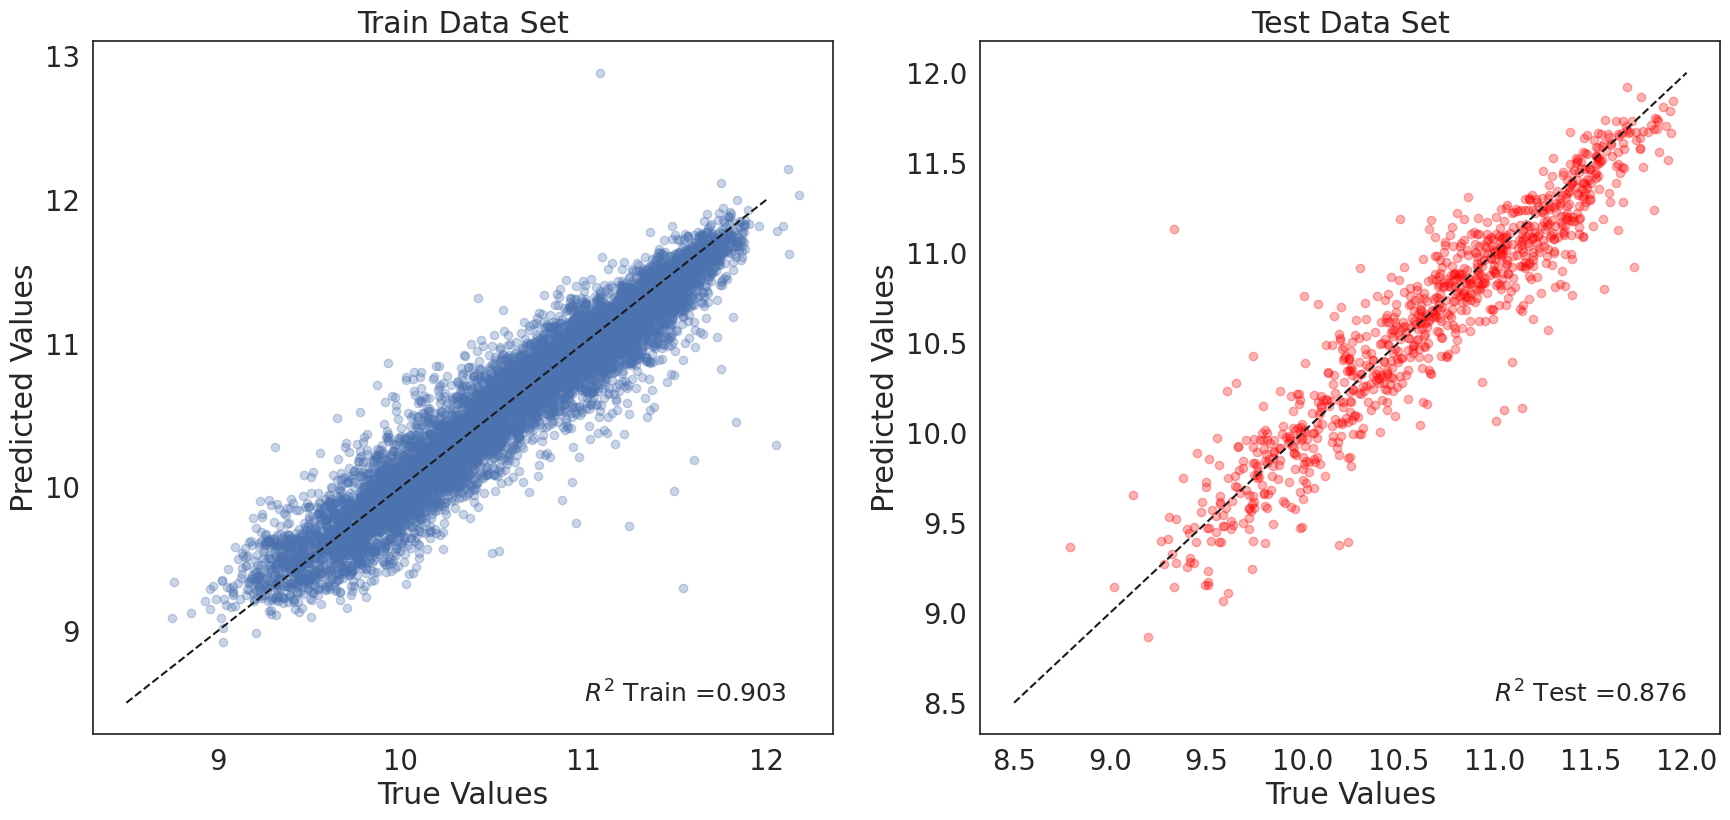

In [17]:
outlier = np.where((np.array(train_mass_list)<13))[0]
outlier_test = np.where((np.array(test_mass_list)<13))[0]

plt.figure(figsize=(21,9))
plt.subplot(1,2,1)
plt.title('Train Data Set')
plt.scatter(np.array(train_mass_list)[outlier],np.array(predictions_train)[outlier],alpha=0.3)
plt.plot([8.5,12],[8.5,12],'k--')
plt.text(11,8.5,'$R^2$ Train ='+str((r2_score(np.array(train_mass_list)[outlier],np.array(predictions_train)[outlier])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.subplot(1,2,2)
plt.title('Test Data Set')
plt.scatter(np.array(test_mass_list)[outlier_test],np.array(predictions_test)[outlier_test],alpha=0.3,c='red')
plt.plot([8.5,12],[8.5,12],'k--')
plt.text(11,8.5,'$R^2$ Test ='+str((r2_score(np.array(test_mass_list)[outlier_test],np.array(predictions_test)[outlier_test])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.savefig('Mass_Accuracy.pdf')

Text(0, 0.5, 'Predicted Values')

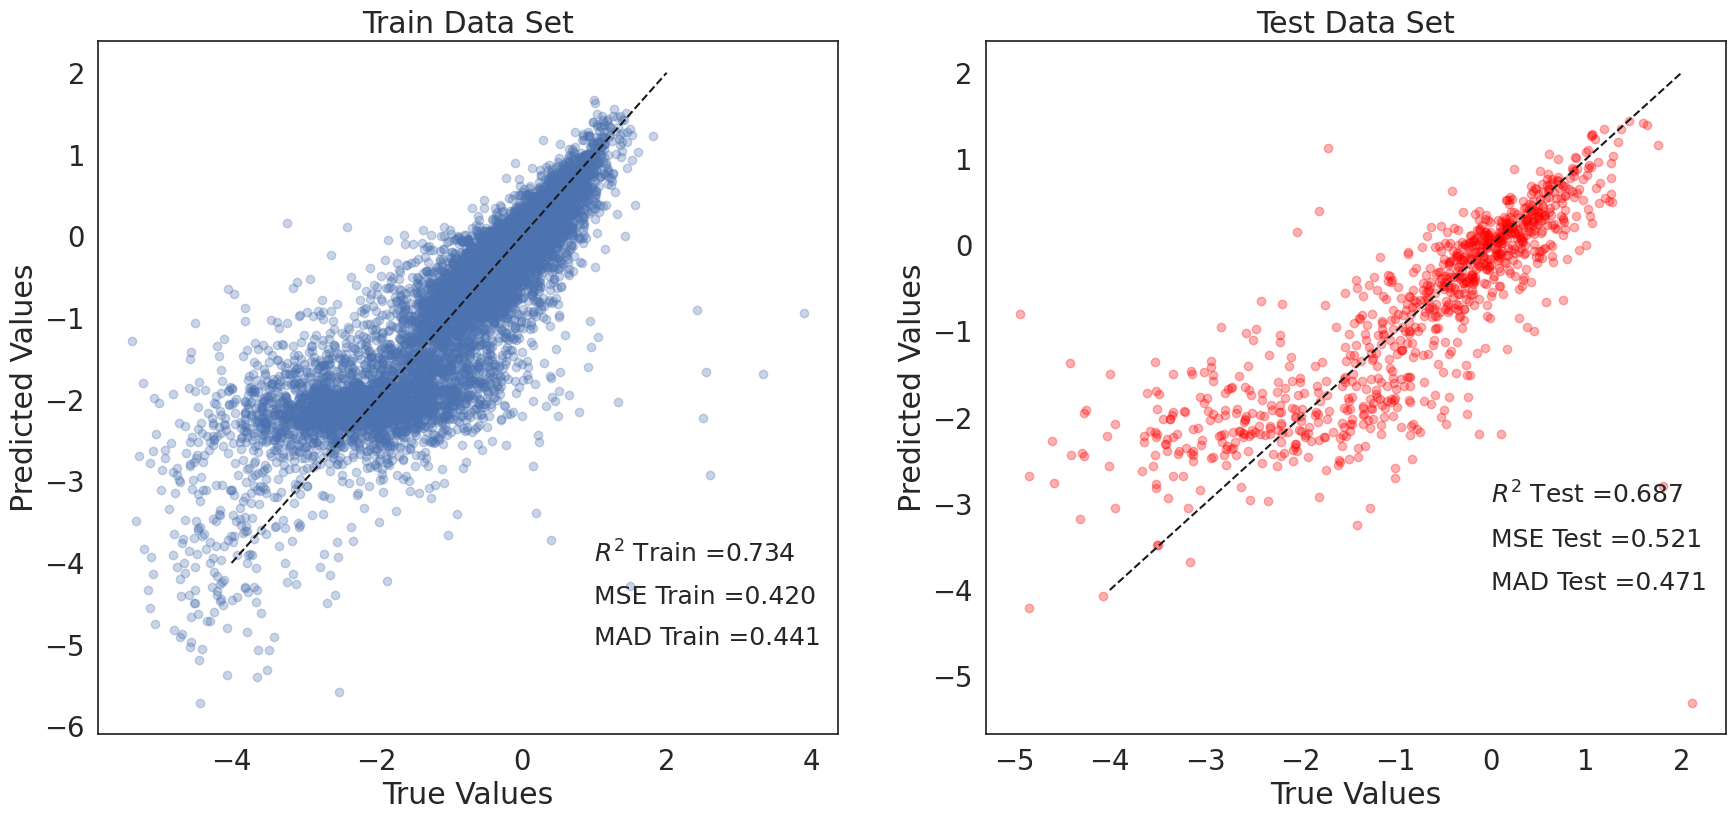

In [75]:

predictions_train_sfr = predictions_train
predictions_test_sfr = predictions_test

outlier_index_train = np.where((np.array(predictions_train_sfr)>-6) & (np.array(predictions_train_sfr)<3))[0]
outlier_index_test = np.where(np.array(predictions_test_sfr)>-6)[0]

# outlier_index_train = np.arange(0,len(predictions_train_sfr))
# outlier_index_test = np.arange(0,len(predictions_test_sfr))

plt.figure(figsize=(21,9))
plt.subplot(1,2,1)
plt.title('Train Data Set')
plt.scatter(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train],alpha=0.3)
plt.plot([-4,2],[-4,2],'k--')
plt.text(1,-4,'$R^2$ Train ='+str((r2_score(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1,-4.5,'MSE Train ='+str((mean_squared_error(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1,-5,'MAD Train ='+str((mean_absolute_error(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.subplot(1,2,2)
plt.title('Test Data Set')
plt.scatter(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test],alpha=0.3,c='red')
plt.plot([-4,2],[-4,2],'k--')
plt.text(0,-3,'$R^2$ Test ='+str((r2_score(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test])))[0:5],fontsize='small')
plt.text(0,-3.5,'MSE Test ='+str((mean_squared_error(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test])))[0:5],fontsize='small')
plt.text(0,-4,'MAD Test ='+str((mean_absolute_error(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

Text(0, 0.5, 'Predicted Values')

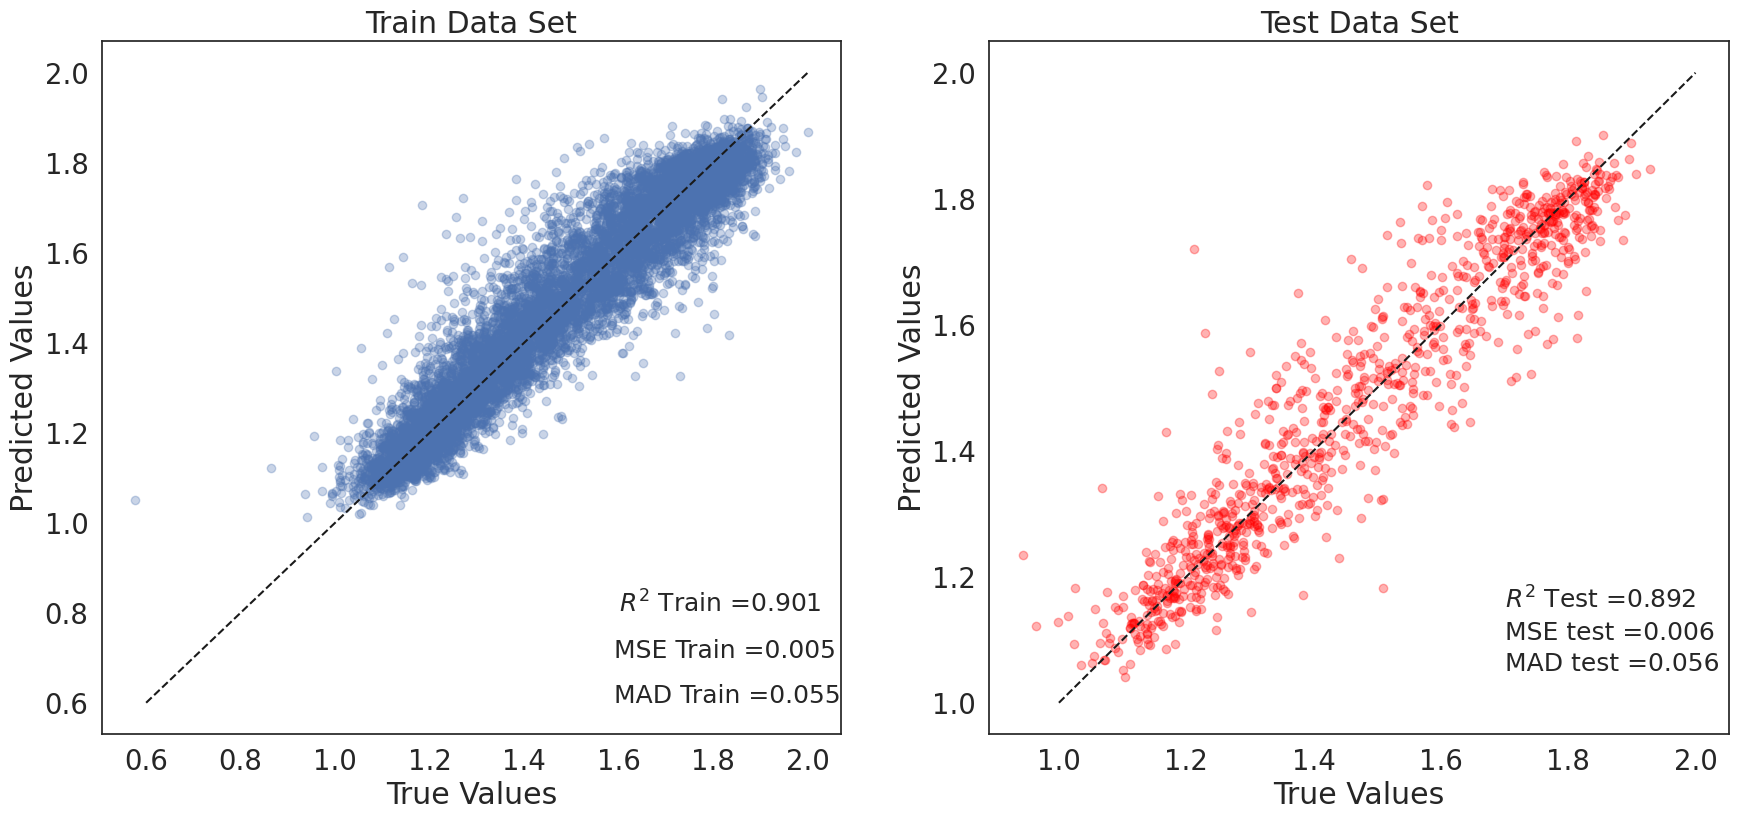

In [59]:
predictions_train_t50 = predictions_train
predictions_test_t50 = predictions_test


outlier_index_train = np.where(np.array(train_t50_list)<4)[0]

plt.figure(figsize=(21,9))
plt.subplot(1,2,1)
plt.title('Train Data Set')
plt.scatter(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train],alpha=0.3)
plt.plot([0.6,2],[0.6,2],'k--')
# plt.ylim(top=2)
plt.text(1.6,0.8,'$R^2$ Train ='+str((r2_score(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1.59,0.7,'MSE Train ='+str((mean_squared_error(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1.59,0.6,'MAD Train ='+str((mean_absolute_error(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.subplot(1,2,2)
plt.title('Test Data Set')
plt.scatter(np.array(test_t50_list),predictions_test_t50,alpha=0.3,c='red')
plt.plot([1,2],[1,2],'k--')
plt.text(1.7,1.15,'$R^2$ Test ='+str((r2_score(np.array(test_t50_list),predictions_test_t50)))[0:5],fontsize='small')
plt.text(1.7,1.1,'MSE test ='+str((mean_squared_error(np.array(test_t50_list)[outlier_index_test],np.array(predictions_test_t50)[outlier_index_test])))[0:5],fontsize='small')
plt.text(1.7,1.05,'MAD test ='+str((mean_absolute_error(np.array(test_t50_list)[outlier_index_test],np.array(predictions_test_t50)[outlier_index_test])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

Text(0, 0.5, 'Predicted Values')

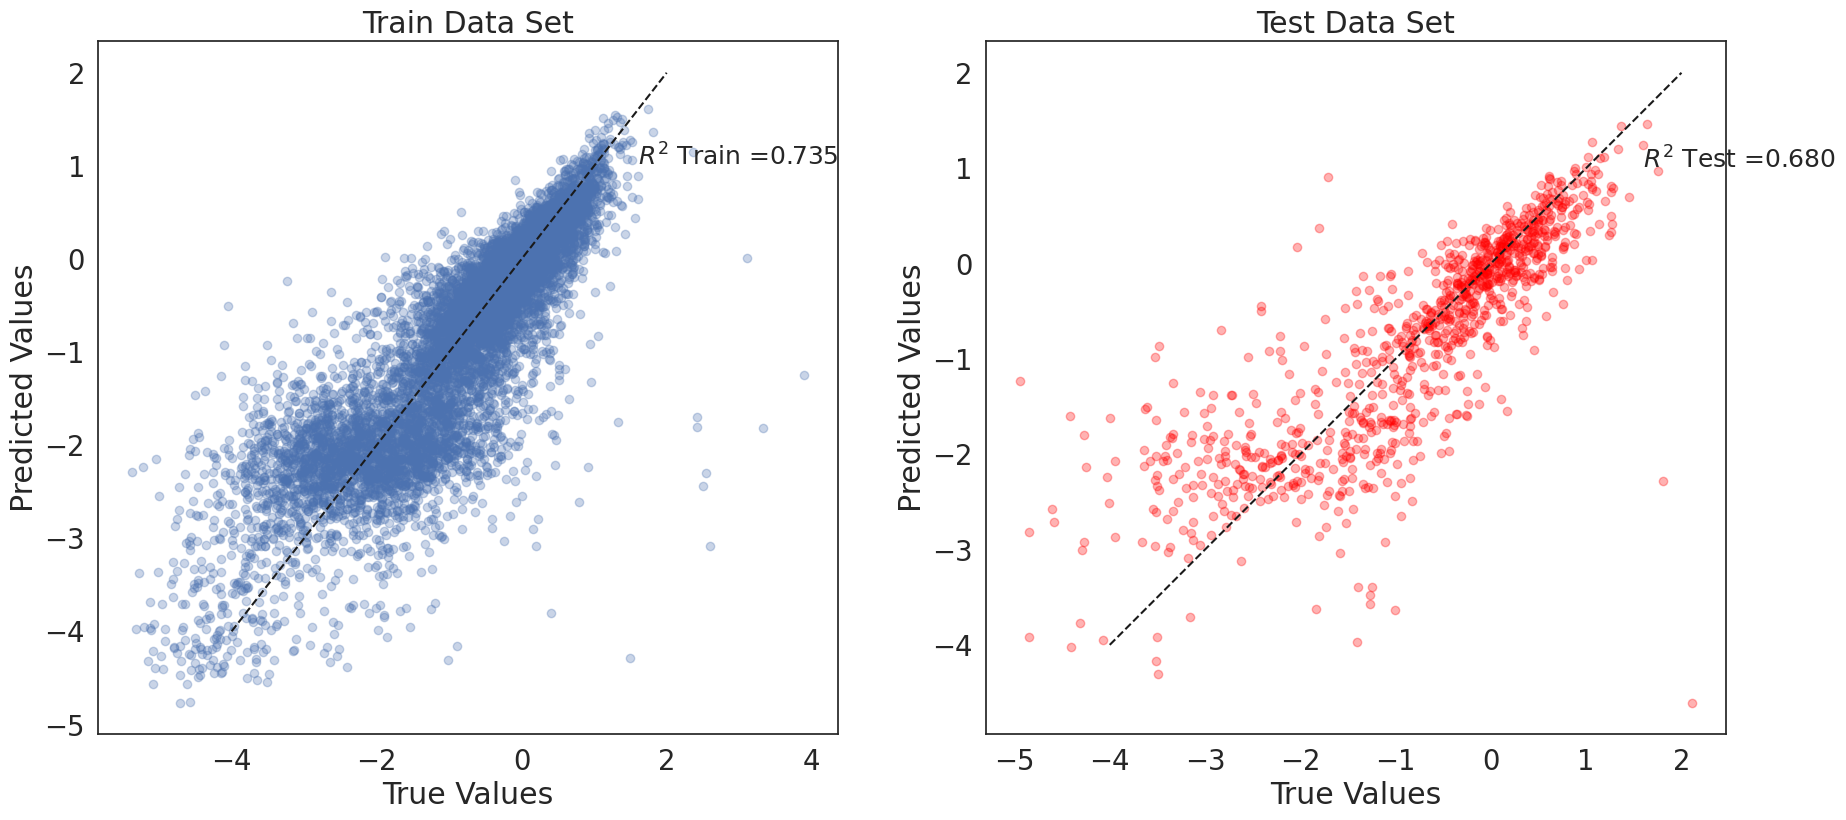

In [23]:
outlier = np.where(np.array(train_t50_list) < 3)[0]


plt.figure(figsize=(21,9))
plt.subplot(1,2,1)
plt.title('Train Data Set')
plt.scatter(np.array(train_sfr_list)[outlier],np.array(predictions_train)[outlier],alpha=0.3)
plt.plot([-4,2],[-4,2],'k--')
plt.text(1.6,1,'$R^2$ Train ='+str((r2_score(train_sfr_list,predictions_train)))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.subplot(1,2,2)
plt.title('Test Data Set')
plt.scatter(test_sfr_list,predictions_test,alpha=0.3,c='red')
plt.plot([-4,2],[-4,2],'k--')
plt.text(1.6,1,'$R^2$ Test ='+str((r2_score(test_sfr_list,predictions_test)))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')


Chain Set-up Analysis

In [11]:
device = 'cuda'
model_used = 'ResNet50_log_t50_chain_90_10'

model_mass = models.resnet50(weights=None)
model_mass.fc = nn.Linear(2048, 1)
model_mass = nn.DataParallel(model_mass,device_ids=(0,1))
model_mass.load_state_dict(torch.load(work_dir+'models/Mass_'+model_used+'.pytorch'),strict=True)#strict is set to false since it was trained on multiple GPUs it causes an error when loaded on the model that is not on multiple GPUs yet
                                                                                                # DO NOT DO THIS!! MESSES WITH THE MODEL PREDECTIONS HEAVILY
model_mass.eval()

model_sfr = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
model_sfr.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,bias=False)
model_sfr.fc = nn.Linear(2048, 1)
model_sfr = nn.DataParallel(model_sfr,device_ids=(0,1))
model_sfr.load_state_dict(torch.load(work_dir+'models/SFR_'+model_used+'.pytorch'),strict=True)
model_sfr.eval()

model_used = 'd4000_chain'

model_t50 = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
model_t50.conv1 = nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3,bias=False)
model_t50.fc = nn.Linear(2048, 1)
model_t50 = nn.DataParallel(model_t50,device_ids=(0,1))
model_t50.load_state_dict(torch.load(work_dir+'models/d4000_'+model_used+'.pytorch'),strict=True)
model_t50.eval()

model_mass, model_sfr, model_t50 = model_mass.to(device), model_sfr.to(device), model_t50.to(device)



In [ ]:
#Run images through the model and extract the predicitions

predictions_train_sfr =[]
predictions_train_t50 =[]

predictions_test_sfr =[]
predictions_test_t50 =[]

incomplete_batch_id_test=len(val_ids)-1

remainder_test=len(val_ids[incomplete_batch_id_test])

total_values_test=(len(val_ids)*batch_size)-(batch_size-remainder_test)

incomplete_batch_id_train=len(train_ids)-1

remainder_train=len(train_ids[incomplete_batch_id_train])

total_values_train=(len(train_ids)*batch_size)-(batch_size-remainder_train)

#Getting predictions for the train set 
for batch_idx, temp in enumerate(train_loader):

    if batch_idx<incomplete_batch_id_train:
        image_batch = temp['image'].to('cuda')
        pred_mass_batch = model_mass(image_batch)
        # print(pred_mass_batch)
        mass_batch = np.zeros((batch_size,1,256,256))

      
        for i in range(batch_size):
            mass_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_mass_batch.detach().cpu().numpy().flatten()[i]
        image_mass_batch = torch.concat((image_batch,torch.tensor(mass_batch).float().to('cuda')),1)

        pred_sfr_batch= model_sfr(image_mass_batch)
        sfr_batch = np.zeros((batch_size,1,256,256))
        for i in range(batch_size):
            sfr_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_sfr_batch.detach().cpu().numpy().flatten()[i]
        

        image_mass_sfr_batch = torch.concat((image_mass_batch,torch.tensor(sfr_batch).float().to('cuda')),1)

        pred_t50_batch = model_t50(image_mass_sfr_batch)

        pred_sfr_batch, pred_t50_batch = pred_sfr_batch.detach().cpu().numpy(), pred_t50_batch.detach().cpu().numpy()
    
        for j in range(batch_size):     
            predictions_train_sfr.append(pred_sfr_batch[j])
            predictions_train_t50.append(pred_t50_batch[j])


    else:
        image_batch = temp['image'].to('cuda')
        pred_mass_batch = model_mass(image_batch)
        mass_batch = np.zeros((remainder_train,1,256,256))
        for i in range(remainder_train):
            mass_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_mass_batch.detach().cpu().numpy().flatten()[i]
        image_mass_batch = torch.concat((image_batch,torch.tensor(mass_batch).float().to('cuda')),1)

        pred_sfr_batch= model_sfr(image_mass_batch)
        sfr_batch = np.zeros((remainder_train,1,256,256))
        for i in range(remainder_train):
            sfr_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_sfr_batch.detach().cpu().numpy().flatten()[i]
        

        image_mass_sfr_batch = torch.concat((image_mass_batch,torch.tensor(sfr_batch).float().to('cuda')),1)

        pred_t50_batch = model_t50(image_mass_sfr_batch)

        pred_sfr_batch, pred_t50_batch = pred_sfr_batch.detach().cpu().numpy(), pred_t50_batch.detach().cpu().numpy()
    
        for k in range(remainder_train):
            predictions_train_sfr.append(pred_sfr_batch[k])
            predictions_train_t50.append(pred_t50_batch[k])




#Getting Predicitions for the Test set 
for batch_idx, temp in enumerate(val_loader):

    if batch_idx<incomplete_batch_id_test:
        image_batch = temp['image'].to('cuda')
        pred_mass_batch = model_mass(image_batch)
        mass_batch = np.zeros((batch_size,1,256,256))
        for i in range(batch_size):
            mass_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_mass_batch.detach().cpu().numpy().flatten()[i]
        image_mass_batch = torch.concat((image_batch,torch.tensor(mass_batch).float().to('cuda')),1)

        pred_sfr_batch= model_sfr(image_mass_batch)
        sfr_batch = np.zeros((batch_size,1,256,256))
        for i in range(batch_size):
            sfr_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_sfr_batch.detach().cpu().numpy().flatten()[i]
        
        
        image_mass_sfr_batch = torch.concat((image_mass_batch,torch.tensor(sfr_batch).float().to('cuda')),1)

        pred_t50_batch = model_t50(image_mass_sfr_batch)

        pred_sfr_batch, pred_t50_batch = pred_sfr_batch.detach().cpu().numpy(), pred_t50_batch.detach().cpu().numpy()

        for j in range(batch_size):     
            predictions_test_sfr.append(pred_sfr_batch[j])
            predictions_test_t50.append(pred_t50_batch[j])


    else:
        image_batch = temp['image'].to('cuda')
        pred_mass_batch = model_mass(image_batch)
        mass_batch = np.zeros((remainder_test,1,256,256))
        for i in range(remainder_test):
            mass_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_mass_batch.detach().cpu().numpy().flatten()[i]
        image_mass_batch = torch.concat((image_batch,torch.tensor(mass_batch).float().to('cuda')),1)

        pred_sfr_batch= model_sfr(image_mass_batch)
        sfr_batch = np.zeros((remainder_test,1,256,256))
        for i in range(remainder_test):
            sfr_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_sfr_batch.detach().cpu().numpy().flatten()[i]
        
        
        image_mass_sfr_batch = torch.concat((image_mass_batch,torch.tensor(sfr_batch).float().to('cuda')),1)
        pred_t50_batch = model_t50(image_mass_sfr_batch)

        pred_sfr_batch, pred_t50_batch = pred_sfr_batch.detach().cpu().numpy(), pred_t50_batch.detach().cpu().numpy()
        
        for k in range(remainder_test):
            predictions_test_sfr.append(pred_sfr_batch[k])
            predictions_test_t50.append(pred_t50_batch[k])



In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

Text(0, 0.5, 'Predicted Values')

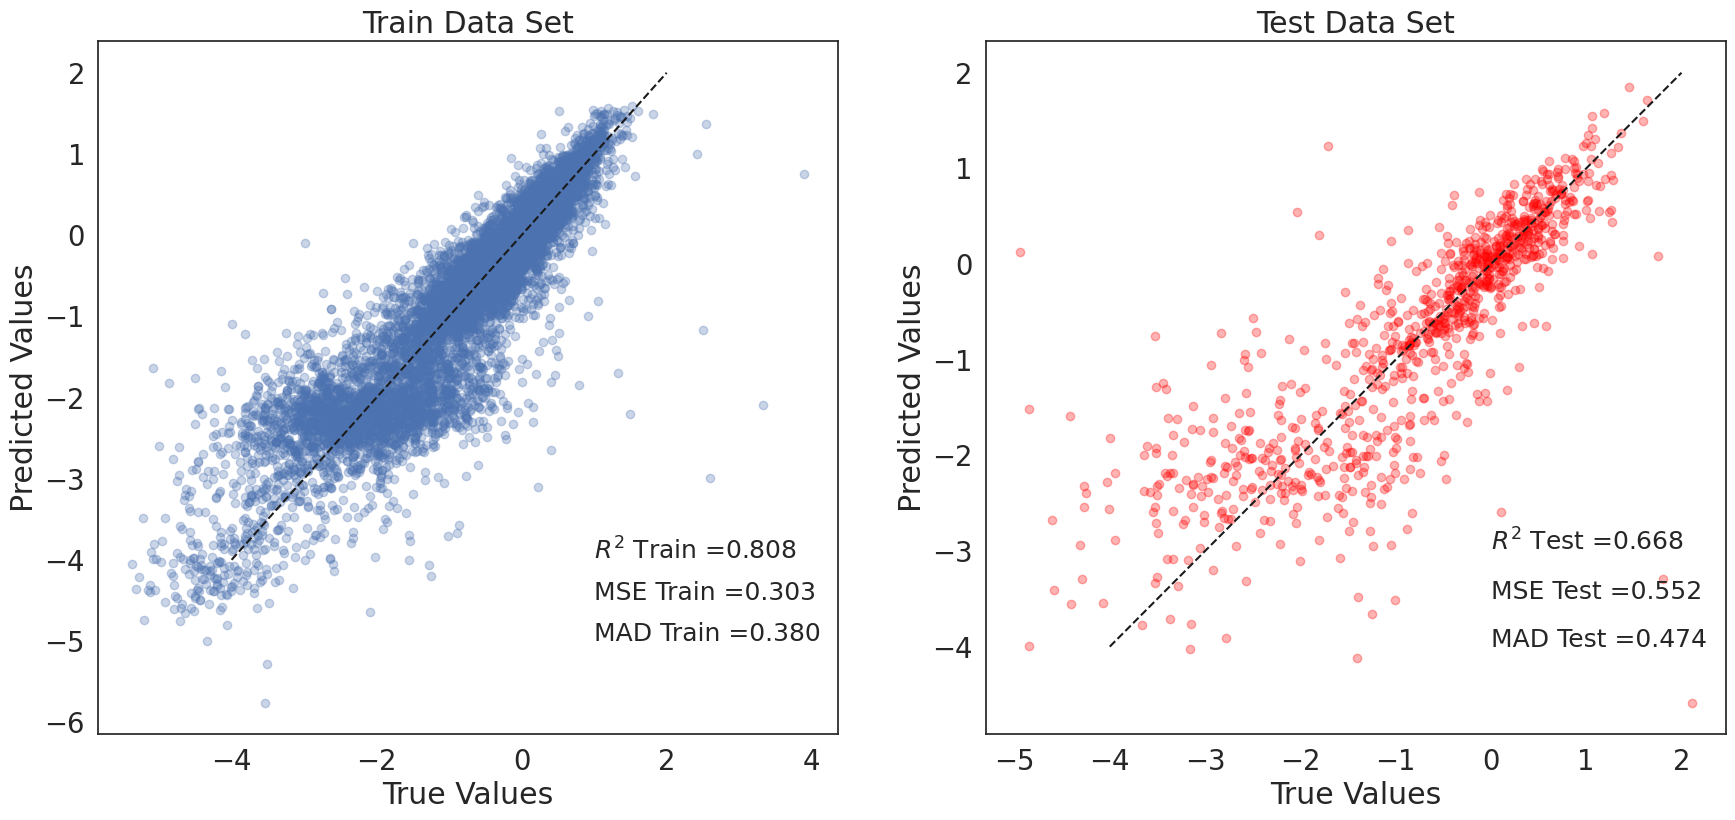

In [14]:
outlier_index_train = np.where((np.array(predictions_train_sfr)>-6) & (np.array(predictions_train_sfr)<3))[0]
outlier_index_test = np.where(np.array(predictions_test_sfr)>-6)[0]

plt.figure(figsize=(21,9))
plt.subplot(1,2,1)
plt.title('Train Data Set')
plt.scatter(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train],alpha=0.3)
plt.plot([-4,2],[-4,2],'k--')
plt.text(1,-4,'$R^2$ Train ='+str((r2_score(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1,-4.5,'MSE Train ='+str((mean_squared_error(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1,-5,'MAD Train ='+str((mean_absolute_error(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.subplot(1,2,2)
plt.title('Test Data Set')
plt.scatter(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test],alpha=0.3,c='red')
plt.plot([-4,2],[-4,2],'k--')
plt.text(0,-3,'$R^2$ Test ='+str((r2_score(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test])))[0:5],fontsize='small')
plt.text(0,-3.5,'MSE Test ='+str((mean_squared_error(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test])))[0:5],fontsize='small')
plt.text(0,-4,'MAD Test ='+str((mean_absolute_error(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

Text(0, 0.5, 'Predicted Values')

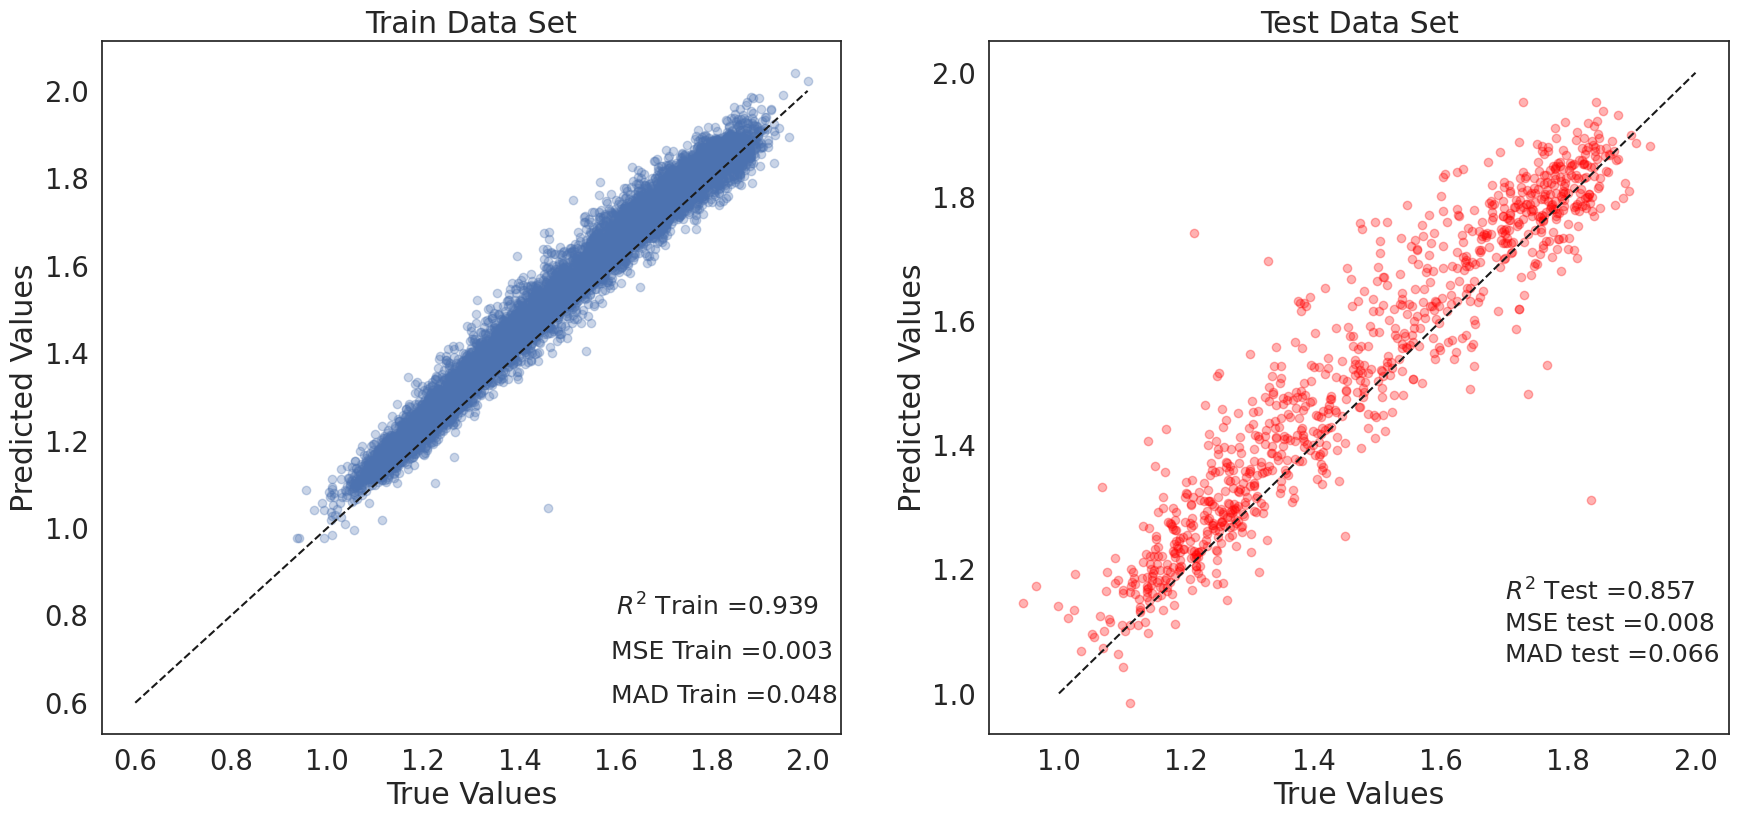

In [15]:
outlier_index_train = np.where((np.array(predictions_train_t50)<10))[0]

plt.figure(figsize=(21,9))
plt.subplot(1,2,1)
plt.title('Train Data Set')
plt.scatter(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train],alpha=0.3)
plt.plot([0.6,2],[0.6,2],'k--')
# plt.ylim(top=2)
plt.text(1.6,0.8,'$R^2$ Train ='+str((r2_score(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1.59,0.7,'MSE Train ='+str((mean_squared_error(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1.59,0.6,'MAD Train ='+str((mean_absolute_error(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.subplot(1,2,2)
plt.title('Test Data Set')
plt.scatter(np.array(test_t50_list),predictions_test_t50,alpha=0.3,c='red')
plt.plot([1,2],[1,2],'k--')
plt.text(1.7,1.15,'$R^2$ Test ='+str((r2_score(np.array(test_t50_list),predictions_test_t50)))[0:5],fontsize='small')
plt.text(1.7,1.1,'MSE test ='+str((mean_squared_error(np.array(test_t50_list)[outlier_index_test],np.array(predictions_test_t50)[outlier_index_test])))[0:5],fontsize='small')
plt.text(1.7,1.05,'MAD test ='+str((mean_absolute_error(np.array(test_t50_list)[outlier_index_test],np.array(predictions_test_t50)[outlier_index_test])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')